# CORDIC core

This notebook visualizes various results obtained from the CORDIC core in [```rtl/cordic.v```](../rtl/cordic.v) using the [```tb/core_test.sv```](../tb/core_test.sv) testbench

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_table_data(filename):
    with open(filename, "r") as f:
        table_found     = False
        summary_found   = False
        while(True):
            s = f.readline().strip()
            if(s == ''):
                break
            if(s == "Test table"):
                table_found = True
                break

        if(not table_found):
            return None
        
        f.readline()
        
        idx_hist = []
        inp_hist = []
        exp_hist = []
        err_hist = []
        sta_hist = []

        while(True):
            inp = f.readline().strip().split(':')
            if(inp[0][0] == '-'):
                break

            if(len(inp) != 3):
                return None

            dat = inp[1].split('|')

            if(len(dat) != 3):
                return None

            idx_hist.append(int(inp[0]))
            inp_hist.append(tuple(map(float, dat[0].split(','))))
            exp_hist.append(tuple(map(float, dat[1].split(','))))
            err_hist.append(tuple(map(float, dat[2].split(','))))
            sta_hist.append(True if inp[2].strip() == "OK" else False)
        
        return (idx_hist, inp_hist, exp_hist, err_hist, sta_hist)

In [4]:
def separate(inp_list, sta_list):
    good_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if sta_list[i]])
    fail_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if not sta_list[i]])
    return good_list, fail_list

In [24]:
def vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail):
    # Scatter plot for input coordintates
    plt.figure(dpi=80)
    plt.scatter(inp_good[:, 0], inp_good[:, 1], s=2, marker="o", c="green", label="Success")
    plt.scatter(inp_fail[:, 0], inp_fail[:, 1], s=5, marker="x", c="red",   label="Overflow")

    plt.xlabel("Input x coordinate")
    plt.ylabel("Input y coordinate")
    plt.title("Input coordinates")
    plt.legend()
    plt.show()

    # Scatter plot for expected coordinates
    plt.figure(dpi=80)
    plt.scatter(exp_good[:, 0], exp_good[:, 1], s=2, marker="o", c="green", label="Success")
    plt.scatter(exp_fail[:, 0], exp_fail[:, 1], s=5, marker="x", c="red",   label="Overflow")

    plt.xlabel("Expected x coordinate")
    plt.ylabel("Expected y coordinate")
    plt.title("Expected output coordinates")
    plt.legend()
    plt.show()

    # Scatter plot for input coordinate magnitude and input rotation angle
    plt.figure(dpi=80)
    plt.scatter(inp_good[:, 2], np.linalg.norm(inp_good[:, 0:2], axis=1), s=2, marker="o", c="green", label="Success")
    plt.scatter(inp_fail[:, 2], np.linalg.norm(inp_fail[:, 0:2], axis=1), s=5, marker="x", c="red",   label="Overflow")

    plt.xlabel("Input angle")
    plt.ylabel("Input coordinate magnitude")
    plt.title("Overflow in terms of input rotation angle and magnitude")
    plt.legend()
    plt.show()

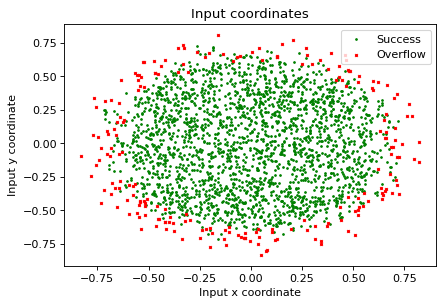

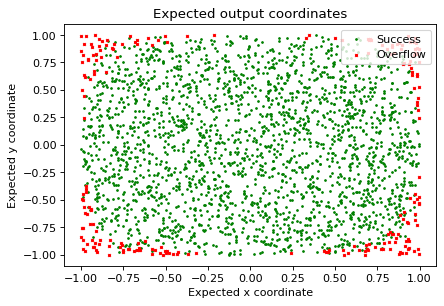

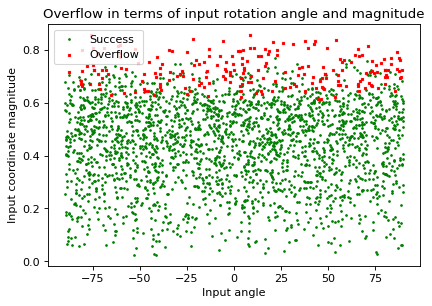

In [27]:
# Read hyperbolic inputs
idx_ls, inp_ls, exp_ls, err_ls, sta_ls = get_table_data("data/circ_rot/cr_10_off_off_x2500.txt")
idx_good, idx_fail = separate(idx_ls, sta_ls)
inp_good, inp_fail = separate(inp_ls, sta_ls)
exp_good, exp_fail = separate(exp_ls, sta_ls)
err_good, err_fail = separate(err_ls, sta_ls)

vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)

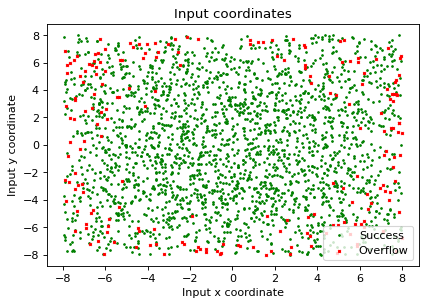

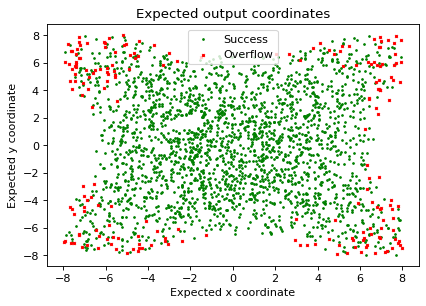

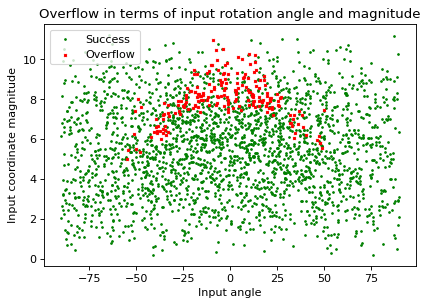

In [25]:
# Read hyperbolic inputs
idx_ls, inp_ls, exp_ls, err_ls, sta_ls = get_table_data("data/hyp_rot/hr_10_off_off_x2500.txt")
idx_good, idx_fail = separate(idx_ls, sta_ls)
inp_good, inp_fail = separate(inp_ls, sta_ls)
exp_good, exp_fail = separate(exp_ls, sta_ls)
err_good, err_fail = separate(err_ls, sta_ls)

vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)